In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import cv2

Инициализирую веса модели, используя случайное распределение Кайминга c дисперсией, зависящей от числа выходных нейронов для ReLU, а также веса батчнорма равные единице и сдвиги равные нулю

In [2]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.skip = (
            nn.Identity()
            if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        )

        mid_channels = out_channels // 2

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        x = x + residual
        return self.relu(x)

class HourglassBlock(nn.Module):
    def __init__(self, in_channels, channels):
        super().__init__()
        
        # Сжатие картинки
        self.down1 = ResidualBlock(in_channels, channels)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ResidualBlock(channels, channels)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ResidualBlock(channels, channels)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ResidualBlock(channels, channels)
        
        # середина модели с неизменной размерностью
        self.center = nn.Sequential(
            ResidualBlock(channels, channels),
            ResidualBlock(channels, channels),
            ResidualBlock(channels, channels)
        )
        
        # Возвращение изначальных размеров
        self.up1 = ResidualBlock(channels, channels)
        self.up2 = ResidualBlock(channels, channels)
        self.up3 = ResidualBlock(channels, channels)
        
        # Прокинутые неизменные слои
        self.upsample1 = nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)
        
        # Батч-нормы после апсемплинга
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.bn3 = nn.BatchNorm2d(channels)
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # сжатие
        d1 = self.down1(x)  # 128×128
        p1 = self.pool1(d1)  # 64×64
        
        d2 = self.down2(p1)  # 64×64
        p2 = self.pool2(d2)  # 32×32
        
        d3 = self.down3(p2)  # 32×32
        p3 = self.pool3(d3)  # 16×16
        
        d4 = self.down4(p3)  # 16×16
        
        # Center
        x = self.center(d4)  # 16×16
        
        # увеличение разрешения с skip connection
        x = self.up1(x)  # 16×16
        x = self.upsample1(x)  # 32×32
        x = self.bn1(x + d3)  # Skip connection
        x = self.relu(x)
        
        x = self.up2(x)  # 32×32
        x = self.upsample2(x)  # 64×64
        x = self.bn2(x + d2)  # Skip connection
        x = self.relu(x)
        
        x = self.up3(x)  # 64×64
        x = self.upsample3(x)  # 128×128
        x = self.bn3(x + d1)  # Skip connection
        x = self.relu(x)
        
        return x

class StackedHourglassNetwork(nn.Module):
    def __init__(self, num_stacks=2, num_keypoints=5, upsample_outputs=False):
        super().__init__()

        self.apply(init_weights)
        self.num_stacks = num_stacks
        self.num_keypoints = num_keypoints
        self.upsample_outputs = upsample_outputs

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )
        
        # Стек hourglass блоков
        self.hourglasses = nn.ModuleList()
        self.output_blocks = nn.ModuleList()  # Блоки для получения heatmaps
        self.merge_blocks = nn.ModuleList()   # Блоки для объединения с next stack
        
        for i in range(num_stacks):
            # Hourglass блок
            if i == 0:
                self.hourglasses.append(HourglassBlock(256, 256))
            else:
                self.hourglasses.append(HourglassBlock(256 + num_keypoints, 256))
            
            self.output_blocks.append(nn.Sequential(
                ResidualBlock(256, 256),
                nn.Conv2d(256, num_keypoints, kernel_size=1)
            ))
            
            # Блок для подготовки к следующему стеку (если не последний)
            if i < num_stacks - 1:
                self.merge_blocks.append(nn.Sequential(
                    nn.Conv2d(256, 256, kernel_size=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True)
                ))

    def forward(self, x):
        original_size = x.shape[2:]
    
        x = self.initial(x)
    
        outputs = []
        low_res_outputs = []
    
        for i in range(self.num_stacks):
            hourglass_output = self.hourglasses[i](x)
    
            low_res_heatmaps = self.output_blocks[i](hourglass_output)
            low_res_heatmaps = torch.sigmoid(low_res_heatmaps)
            low_res_outputs.append(low_res_heatmaps)
            #Если бы оперативка позволяла - можно было бы довести размер хитмапов до 256x256, тем самым еще чуть точность повысить, но у меня даже так батч размером 8 фотографий почти полностью занимал память
            if self.upsample_outputs:
                heatmaps = F.interpolate(
                    low_res_heatmaps,
                    size=original_size,
                    mode='bilinear',
                    align_corners=False
                )
                outputs.append(heatmaps)
            else:
                outputs.append(low_res_heatmaps)
    
            if i < self.num_stacks - 1:
                features = self.merge_blocks[i](hourglass_output)
                x = torch.cat([features, low_res_heatmaps], dim=1)
    
        return outputs

In [4]:
def load_processed_datasets(data_dir=r"../datasets"):

    print(f"Загрузка датасетов из {data_dir}...")
    
    train_df = pd.read_csv(f"{data_dir}/processed_train_dataset.csv")
    val_df = pd.read_csv(f"{data_dir}/processed_val_dataset.csv")
    test_df = pd.read_csv(f"{data_dir}/processed_test_dataset.csv")

    
    print(f"Загружено:")
    print(f"   Train: {len(train_df)} записей")
    print(f"   Val: {len(val_df)} записей")
    print(f"   Test: {len(test_df)} записей")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = load_processed_datasets()

Загрузка датасетов из ../datasets...
Загружено:
   Train: 19028 записей
   Val: 2378 записей
   Test: 2379 записей


In [5]:
device = torch.device('cuda')

In [6]:
class FaceKeypointsDataset(Dataset):
    def __init__(self, dataframe, image_size=256, heatmap_size=128, sigma=2):

        self.df = dataframe
        self.image_size = image_size
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        
        # Кэширование путей для скорости
        self.image_paths = self.df['path'].tolist()
        self.bboxes = self.df[['x_1', 'y_1', 'width', 'height']].values
        
        # Предвычисление нормализованных координат
        self.keypoints_norm = []
        for i in range(1, 6):
            self.keypoints_norm.append(self.df[f'x{i}_bbox_norm'].values)
            self.keypoints_norm.append(self.df[f'y{i}_bbox_norm'].values)
        self.keypoints_norm = np.column_stack(self.keypoints_norm)  # [N, 10]
        
        # Трансформации
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
        print(f"Dataset создан: {len(self)} изображений")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Загрузка и обрезка изображения
        img = Image.open(self.image_paths[idx]).convert('RGB')
        x1, y1, w, h = self.bboxes[idx]
        x2, y2 = x1 + w, y1 + h
        
        # Проверяем границы
        if x1 >= 0 and y1 >= 0 and x2 <= img.width and y2 <= img.height:
            img = img.crop((x1, y1, x2, y2))
        
        # Ресайз
        img = img.resize((self.image_size, self.image_size))
        
        # Конвертация в тензор и нормализация
        img_tensor = self.to_tensor(img)
        img_tensor = self.normalize(img_tensor)
        
        # Ключевые точки
        keypoints = self.keypoints_norm[idx].reshape(5, 2).astype(np.float32)
        
        # Heatmaps
        heatmaps = self.create_heatmaps(keypoints)
        
        return {
            'image': img_tensor,
            'heatmaps': torch.FloatTensor(heatmaps),
            'keypoints': torch.FloatTensor(keypoints),
            'image_id': self.df.iloc[idx]['image_id']
        }
    
    def create_heatmaps(self, keypoints_norm):
        #Создание heatmaps для ключевых точек
        heatmaps = np.zeros((5, self.heatmap_size, self.heatmap_size), 
                           dtype=np.float32)
        
        # Масштабируем координаты
        scaled_points = keypoints_norm * self.heatmap_size
        
        for i in range(5):
            x, y = scaled_points[i]
            x_int, y_int = int(x), int(y)
            
            if 0 <= x_int < self.heatmap_size and 0 <= y_int < self.heatmap_size:
                # Создаем сетку
                xx, yy = np.meshgrid(np.arange(self.heatmap_size), 
                                    np.arange(self.heatmap_size))
                
                heatmap = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * self.sigma**2))
                heatmaps[i] = heatmap
        
        return heatmaps

In [7]:
def create_dataloaders(train_df, val_df, test_df, batch_size=8, pin_memory=True):
    
    train_dataset = FaceKeypointsDataset(
        train_df,
        image_size=256,
        heatmap_size=128,
        sigma=2)
    
    val_dataset = FaceKeypointsDataset(
        val_df,
        image_size=256,
        heatmap_size=128,
        sigma=2)
    
    test_dataset = FaceKeypointsDataset(
        test_df,
        image_size=256,
        heatmap_size=128,
        sigma=2)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=pin_memory)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory)
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory)

    return train_loader, val_loader, test_loader

In [8]:
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, path):
    #Сохраняем чекпоинт
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    #Загружаем чекпоинт
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss']

def train(model, train_loader, val_loader, num_epochs=3):

    print(f"Device: {device}")
    
    # Переносим модель на устройство
    model = model.to(device)
    
    # Оптимизатор и лосс
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    
    # История обучения
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = 100000.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        model.train()
        train_loss = 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)
        
        for batch in train_bar:
            # Загрузка данных
            images = batch['image'].to(device)
            heatmaps = batch['heatmaps'].to(device)
            
            # Forward
            outputs = model(images)
            loss = 0.0
            for stack_output in outputs:
                loss += criterion(stack_output, heatmaps)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Статистика
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        #Валидация
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            
            for batch in val_bar:
                images = batch['image'].to(device)
                heatmaps = batch['heatmaps'].to(device)
                
                outputs = model(images)[-1]
                loss = criterion(outputs, heatmaps)
                val_loss += loss.item()
                
                val_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        # Сохраняем лучшую модель
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(
                model, optimizer, epoch, 
                avg_train_loss, avg_val_loss,
                r'..\weights\hourglass_model.pth'
            )
            print(f"Сохранена лучшая модель (val_loss: {avg_val_loss:.4f})")
        
    return history


def evaluate(model, test_loader):
    #Оценка модели на тестовом наборе
    model.eval()
    
    criterion = nn.MSELoss()
    test_loss = 0
    distances = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            images = batch['image'].to(device)
            heatmaps = batch['heatmaps'].to(device)
            
            outputs = model(images)[-1]
            loss = criterion(outputs, heatmaps)
            test_loss += loss.item()
            
            # Конвертируем heatmaps в координаты и считаем ошибку
            batch_size, num_points, h, w = outputs.shape
            scale = 2
            
            for i in range(batch_size):
                for p in range(num_points):
                    # предикты
                    pred_map = outputs[i, p].cpu().numpy()
                    pred_idx = pred_map.argmax()
                    pred_y, pred_x = divmod(pred_idx, w)
                    pred_x, pred_y = pred_x * scale, pred_y * scale
                    
                    # исходные точки
                    gt_map = heatmaps[i, p].cpu().numpy()
                    gt_idx = gt_map.argmax()
                    gt_y, gt_x = divmod(gt_idx, w)
                    gt_x, gt_y = gt_x * scale, gt_y * scale
                    
                    # Расстояние между исходной точкой и предсказанием
                    dist = ((pred_x - gt_x)**2 + (pred_y - gt_y)**2)**0.5
                    distances.append(dist)
    
    avg_loss = test_loss / len(test_loader)
    avg_distance = sum(distances) / len(distances)
    
    print(f"\nРезультаты теста:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Avg Distance: {avg_distance:.2f} px")
    
    # Accuracy при пороге 5 пикселей и 10 пикселей
    accuracy_5px = sum(1 for d in distances if d < 5) / len(distances)
    accuracy_10px = sum(1 for d in distances if d < 10) / len(distances)
    print(f"  Accuracy (5px): {accuracy_5px:.2%}")
    print(f"  Accuracy (10px): {accuracy_10px:.2%}")
    
    return avg_loss, avg_distance

In [9]:
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df, batch_size=8)
    
model = StackedHourglassNetwork(num_stacks=2, num_keypoints=5)

history = train(model, train_loader, val_loader, num_epochs=2)

Dataset создан: 19028 изображений
Dataset создан: 2378 изображений
Dataset создан: 2379 изображений
Device: cuda

Epoch 1/2
--------------------------------------------------


Сохранена лучшая модель (val_loss: 0.0001)

Epoch 2/2
--------------------------------------------------


Сохранена лучшая модель (val_loss: 0.0001)


In [10]:
# Тестируем
evaluate(model, test_loader)

Testing: 100%|██████████| 298/298 [01:22<00:00,  3.62it/s]


Результаты теста:
  Loss: 0.0001
  Avg Distance: 1.92 px
  Accuracy (5px): 96.20%
  Accuracy (10px): 98.79%


(8.482918523770801e-05, np.float64(1.9213968925581684))

In [11]:
def visualize_predictions_and_gt(model, dataloader, num_samples=5, device=None):
    model.eval()
    model.to(device)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))
    if num_samples == 1:
        axes = [axes]
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx >= num_samples:
                break
                
            image = batch['image'][0].to(device)
            heatmaps = batch['heatmaps'][0]
            gt_keypoints = batch['keypoints'][0].numpy() * 256  # Денормализуем
            
            outputs = model(image.unsqueeze(0))[-1][0]
            
            # Обратная нормализация для изображения
            img_np = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)
            
            # Получаем предсказанные точки
            pred_points = []
            for i in range(5):
                heatmap = outputs[i].cpu().numpy()
                h, w = heatmap.shape
                y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)
                pred_points.append((int(x * 2), int(y * 2)))  # scale 2x
            
            # Визуализация Ground Truth
            ax_gt = axes[0, idx] if num_samples > 1 else axes[0]
            ax_gt.imshow(img_np)
            for i, (x, y) in enumerate(gt_keypoints):
                ax_gt.scatter(x, y, c='red', s=100, marker='o', 
                            edgecolors='white', linewidth=2, label=f'GT {i+1}')
            ax_gt.set_title(f'Фотография {idx+1} - Исходные точки(GT)')
            ax_gt.axis('off')
            
            # Визуализация Predictions
            ax_pred = axes[1, idx] if num_samples > 1 else axes[1]
            ax_pred.imshow(img_np)
            for i, (x, y) in enumerate(pred_points):
                ax_pred.scatter(x, y, c='blue', s=100, marker='x', linewidth=3, label=f'Pred {i+1}')
            ax_pred.set_title(f'Фотография {idx+1} - Предсказание')
            ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

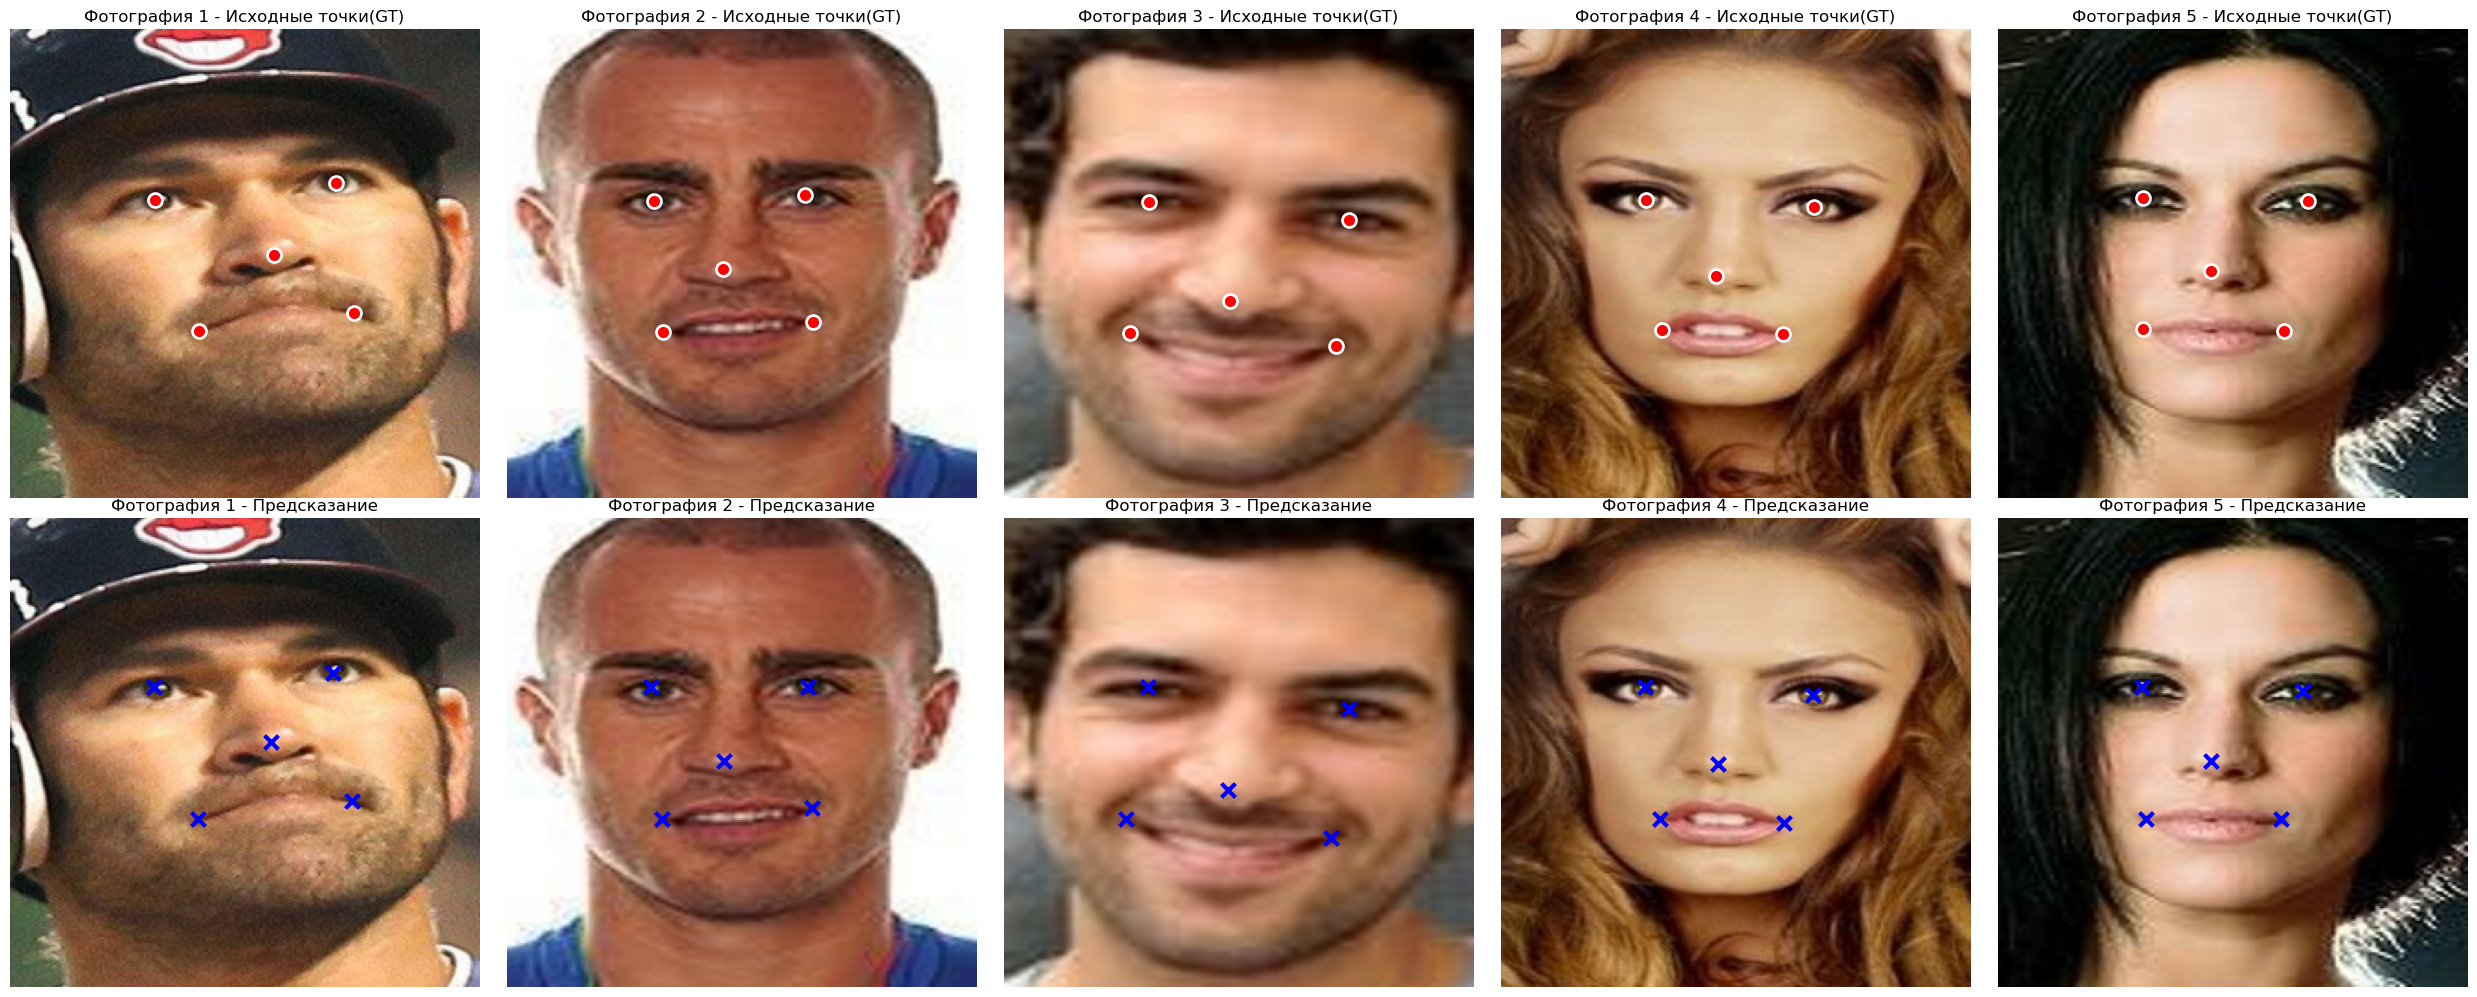

In [12]:
visualize_predictions_and_gt(model, test_loader, num_samples=5, device=device)

In [13]:
def get_coordinates_from_heatmaps(heatmaps_tensor, original_img_size=(256, 256)):
    device = heatmaps_tensor.device
    heatmaps = heatmaps_tensor.cpu().numpy()
    
    # Проверяем размерность
    if len(heatmaps.shape) == 4:  # [batch, 5, H, W]
        batch_size = heatmaps.shape[0]
        num_points = heatmaps.shape[1]
        h_heatmap, w_heatmap = heatmaps.shape[2], heatmaps.shape[3]
    elif len(heatmaps.shape) == 3:  # [5, H, W] - одиночный пример
        batch_size = 1
        num_points = heatmaps.shape[0]
        h_heatmap, w_heatmap = heatmaps.shape[1], heatmaps.shape[2]
        heatmaps = heatmaps.reshape(1, num_points, h_heatmap, w_heatmap)
    
    h_orig, w_orig = original_img_size[1], original_img_size[0]
    
    scale_x = w_orig / w_heatmap
    scale_y = h_orig / h_heatmap
    
    all_points = []
    for b in range(batch_size):
        points = []
        for i in range(num_points):  # 5 точек
            heatmap = heatmaps[b, i]
            y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)
            
            # Масштабируем к оригинальному размеру
            x_scaled = x * scale_x
            y_scaled = y * scale_y
            
            points.append([x_scaled, y_scaled])
        all_points.append(points)
    
    points_array = np.array(all_points, dtype=np.float32)
    
    if len(heatmaps_tensor.shape) == 3:  # Если был одиночный пример
        return points_array[0]  # [5, 2]
    return points_array  # [batch_size, 5, 2]

Тут начинается (и благо кончается) какая-то серьезная математика с преобразованиями, в которой необходимо хоть немного разобраться

In [14]:
def align_with_homography(image, predicted_points, output_size=(256, 256)):
    h, w = output_size[1], output_size[0]
    ref_points = np.array([
    [0.34 * w, 0.46 * h],   # левый глаз
    [0.66 * w, 0.46 * h],   # правый глаз
    [0.50 * w, 0.64 * h],   # нос
    [0.37 * w, 0.82 * h],   # левый угол рта
    [0.63 * w, 0.82 * h]    # правый угол рта
    ])
    
    # Вычисляем матрицу гомографии (perspective transform)
    H, mask = cv2.findHomography(predicted_points, ref_points, cv2.RANSAC, 5.0)
    '''И что же представляет из себя эта матрица гомографии. Это есть матрица 3х3, в которой 8 параметров являются переменными,
    а один - масштаб, фиксированным. С помощью одного из алгоритмов (в данном случае RANSAC) эта функция находит коэффициенты матрицы гомографии,
    обеспечивающие наилучший переход исходного изображения к целевому виду. Порог 5.0 определяет максимальное допустимое расстояние (в пикселях) между 
    преобразованной точкой и эталонной - точки с большим расстоянием считаются выбросами и исключаются из расчета.'''
    
    # Применяем преобразование к изображению
    aligned = cv2.warpPerspective(image, H, output_size, 
                                  flags=cv2.INTER_LINEAR)
    '''Тут происходит преобразование всех пикселей с помощью найденной ранее матрицы, параметр flags отвечает за режим интерполяции,
    в данном случае используется билинейная(считает цвет нового пикселя на основе взвешенного среднего ближайших четырех'''
    return aligned, H

In [20]:
def align_with_affine(image, predicted_points, output_size=(256, 256)):
    #Аффинное преобразование
    h, w = output_size[1], output_size[0]
    
    # Целевые точки для аффинного преобразования
    ref_points = np.array([
    [0.34 * w, 0.46 * h],   # левый глаз
    [0.66 * w, 0.46 * h],   # правый глаз
    [0.50 * w, 0.64 * h],   # нос
    [0.37 * w, 0.82 * h],   # левый угол рта
    [0.63 * w, 0.82 * h]    # правый угол рта
    ], dtype=np.float32)
    
    # Используем первые 3 точки (глаза и нос) - попытки испоьлзовать большее число точек превращало лицо после преобразования в нечто страшное
    src_tri = predicted_points[:3]
    dst_tri = ref_points[:3]
    
    # Получаем матрицу аффинного преобразования, она в отличие от матрицы гомографии содержит 6 параметров (исключены два параметра отвечающие за перспективу изображений)
    M = cv2.getAffineTransform(src_tri, dst_tri)
    
    # Применяем аффинное преобразование - параметры используются такие же, как и в матрице гомографии
    aligned = cv2.warpAffine(
        image, M, output_size,
        flags=cv2.INTER_LINEAR)
    
    return aligned, M

def align_with_similarity(image, predicted_points, output_size=(256, 256)):
    #Преобразование подобия - тоже в своем роде афинное преобразование, но оно уже использует только две точки, а именно глаза.
    h, w = output_size[1], output_size[0]
    
    # Используем только глаза для определения поворота и масштаба
    left_eye = predicted_points[0]
    right_eye = predicted_points[1]
    
    # Целевые положения глаз
    target_left = np.array([0.34 * w, 0.46 * h])
    target_right = np.array([0.66 * w, 0.46 * h])
    
    # Вычисляем текущее и целевое расстояние между глазами
    current_eye_dist = np.linalg.norm(right_eye - left_eye)
    target_eye_dist = np.linalg.norm(target_right - target_left)
    
    # Масштаб
    scale = (target_eye_dist + 1e-7) / (current_eye_dist + 1e-7)
    
    #Находим разность между углами целевого и нынешнего векторов - именно на него будет повёрнуто изображение 
    current_vec = right_eye - left_eye #текущий вектор
    target_vec = target_right - target_left #целевой
    angle = np.degrees(np.arctan2(current_vec[1], current_vec[0]) - 
                       np.arctan2(target_vec[1], target_vec[0]))
    
    # Центр поворота - середина между глазами
    center = (left_eye + right_eye) / 2
    target_center = (target_left + target_right) / 2
    
    # Матрица преобразования
    M = cv2.getRotationMatrix2D(tuple(center), angle, scale)
    
    # Корректируем смещение - необходимо чтобы поместить лица на изображениях в одно и то же место
    M[0, 2] += target_center[0] - center[0]
    M[1, 2] += target_center[1] - center[1]

    #И вновь финальным шагом обрабатываем изображения с теми же параметрами flags
    aligned = cv2.warpAffine(
        image, M, output_size,
        flags=cv2.INTER_LINEAR)
    
    return aligned, M

In [21]:
def compare_alignment_methods(model, image_tensor):
    model.eval()
    
    with torch.no_grad():
        # Получаем предсказанные heatmaps
        heatmaps = model(image_tensor.unsqueeze(0).to(device))[-1]  # [1, 5, 128, 128]
        
        # Конвертируем изображение
        img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        
        # Денормализация
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        img_np = (img_np * 255).astype(np.uint8)
        img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        
        points = get_coordinates_from_heatmaps(heatmaps[0], original_img_size=(256, 256))
        
        # Пробуем разные методы
        methods = [
            ('Гомография (5 точек)', align_with_homography),
            ('Аффинное (3 точки)', align_with_affine),
            ('Подобие (2 точки)', align_with_similarity)
        ]
        
        # Создаем фигуру
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        # Оригинальное изображение
        img_display = cv2.cvtColor(img_np_bgr, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_display)
        for i, (x, y) in enumerate(points):
            axes[0].scatter(x, y, s=50, c='red')
            axes[0].text(x+5, y+5, str(i), color='yellow', fontsize=8)
        axes[0].set_title('Оригинал с точками')
        axes[0].axis('off')
        
        # Применяем методы
        for idx, (name, func) in enumerate(methods):
            aligned_bgr, _ = func(img_np_bgr.copy(), points.copy())
            aligned_rgb = cv2.cvtColor(aligned_bgr, cv2.COLOR_BGR2RGB)
            axes[idx+1].imshow(aligned_rgb)
            axes[idx+1].set_title(f'{name}')
            axes[idx+1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    return points

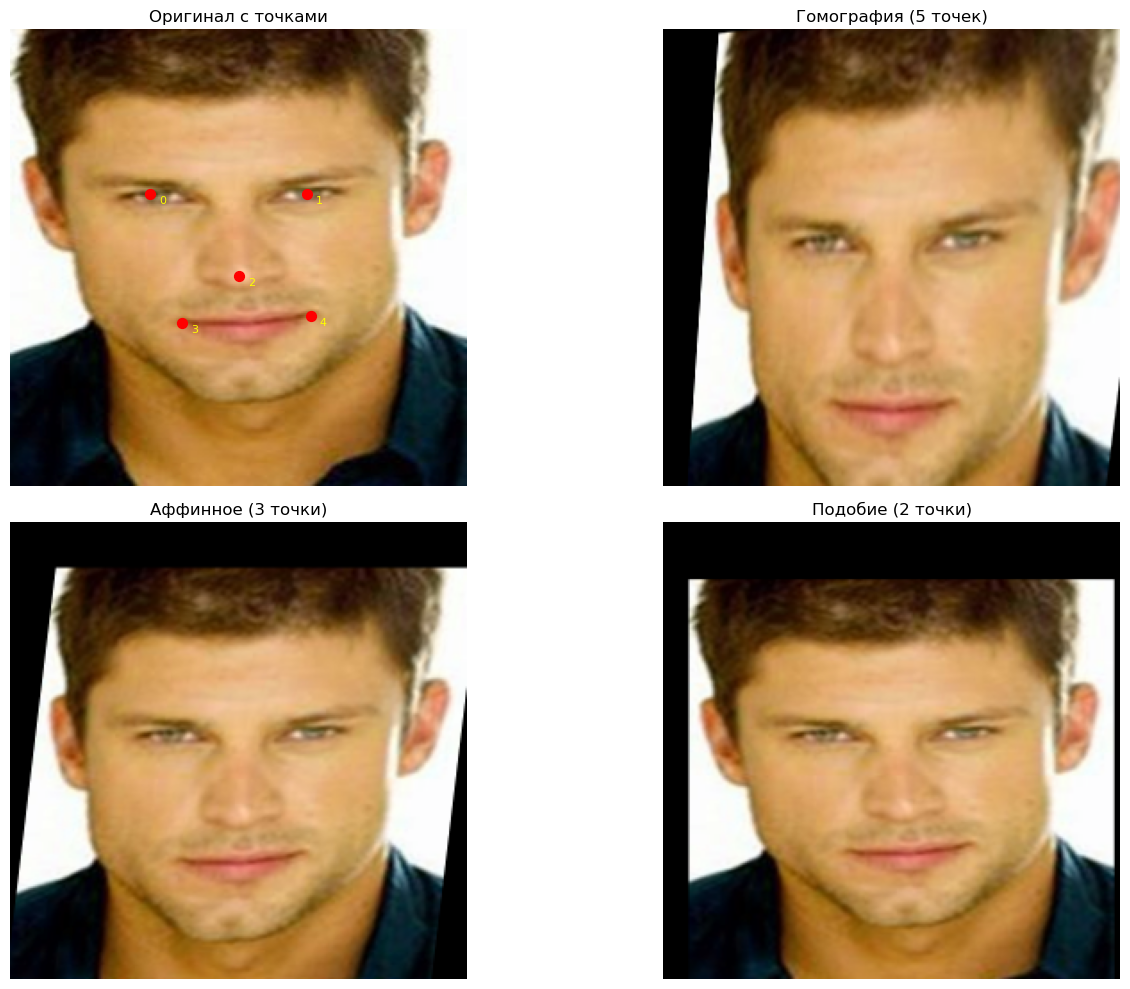

array([[ 78.,  92.],
       [166.,  92.],
       [128., 138.],
       [ 96., 164.],
       [168., 160.]], dtype=float32)

In [27]:
for batch in train_loader:
    image_tensor = batch['image'][3]
    break
compare_alignment_methods(model, image_tensor)

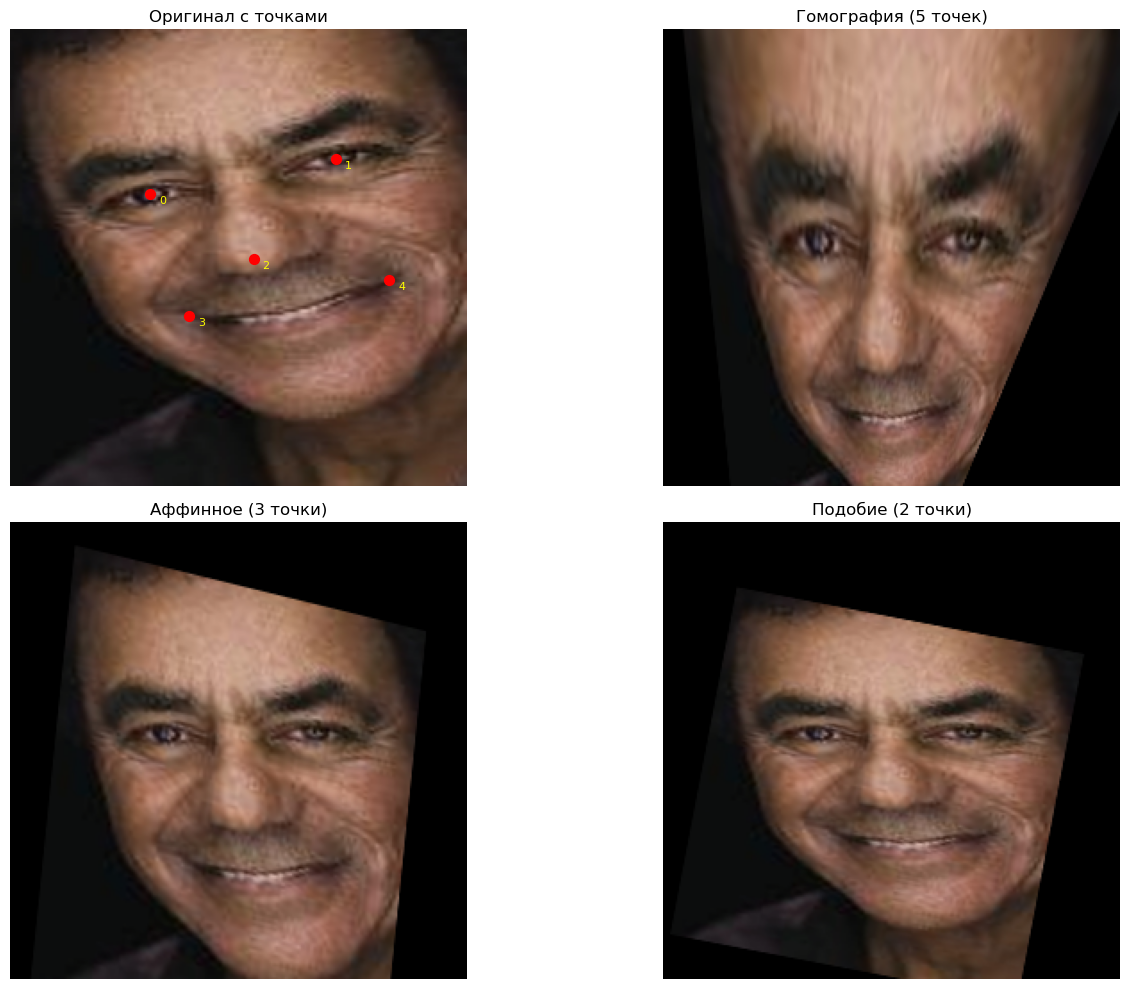

array([[ 78.,  92.],
       [182.,  72.],
       [136., 128.],
       [100., 160.],
       [212., 140.]], dtype=float32)

In [26]:
for batch in train_loader:
    image_tensor = batch['image'][3]
    break
compare_alignment_methods(model, image_tensor)

Лично для моего глаза наиболее приятно изображение с преобразованием подобия, выберу его

In [28]:
def process_dataset_sequential(model, dataloader, output_dir):
    model.eval()
    model.to(device)
    
    os.makedirs(output_dir, exist_ok=True)
    
    aligned_paths = []
    
    for batch in tqdm(dataloader, desc="Processing images"):
        images = batch['image']
        image_ids = batch['image_id']
        
        for i in range(len(images)):
            image_tensor = images[i]
            image_id = image_ids[i]
            
            with torch.no_grad():
                # Предсказание
                heatmaps_list = model(image_tensor.unsqueeze(0).to(device))
                heatmaps = heatmaps_list[-1][0]  # [5, 128, 128]
                
                # Получаем точки
                points = get_coordinates_from_heatmaps(heatmaps, original_img_size=(256, 256))
                
                # Конвертируем изображение
                img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
                
                # Денормализация
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = img_np * std + mean
                img_np = np.clip(img_np, 0, 1)
                img_np = (img_np * 255).astype(np.uint8)
                img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                aligned, _ = align_with_similarity(img_np_bgr, points)
                
                # Сохраняем
                save_path = os.path.join(output_dir, f"{image_id[:-4]}_aligned.jpg")
                cv2.imwrite(save_path, aligned)
                
                aligned_paths.append({
                    'image_id': image_id,
                    'path': save_path,
                    'success': True,
                    'points': points.tolist() if hasattr(points, 'tolist') else points
                })

    return aligned_paths

In [29]:
def create_aligned_dataset(df, aligned_paths, split_name):

    # Создаем словарь для быстрого поиска по image_id
    path_dict = {item['image_id']: item['path'] for item in aligned_paths}
    
    aligned_data = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Creating {split_name} dataframe"):
        image_id = row['image_id']
        
        aligned_data.append({
            'image_id': image_id,
            'person': row['person'],
            'path': path_dict[image_id],
        })
    
    return pd.DataFrame(aligned_data)

In [30]:
model = StackedHourglassNetwork(num_stacks=2, num_keypoints=5).to(device)
checkpoint = torch.load(r'..\weights\hourglass_model.pth', map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Создаем структуру папок
base_dir = r"..\datasets"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val") 
test_dir = os.path.join(base_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Обрабатываем train датасет
print("\nОбработка TRAIN датасета")
train_paths = process_dataset_sequential(model, train_loader, train_dir)

# Обрабатываем val датасет
print("\nОбработка VAL датасета")
val_paths = process_dataset_sequential(model, val_loader, val_dir)

# Обрабатываем test датасет
print("\nОбработка TEST датасета")
test_paths = process_dataset_sequential(model, test_loader, test_dir)

# Создаем DataFrame
train_aligned_df = create_aligned_dataset(train_df, train_paths, 'train')
val_aligned_df = create_aligned_dataset(val_df, val_paths, 'val')
test_aligned_df = create_aligned_dataset(test_df, test_paths, 'test')

# Сохраняем CSV
train_aligned_df.to_csv(os.path.join(base_dir, "train_aligned.csv"), index=False)
val_aligned_df.to_csv(os.path.join(base_dir, "val_aligned.csv"), index=False)
test_aligned_df.to_csv(os.path.join(base_dir, "test_aligned.csv"), index=False)


Обработка TRAIN датасета


Processing images: 100%|██████████| 2379/2379 [19:23<00:00,  2.04it/s]



Обработка VAL датасета


Processing images: 100%|██████████| 298/298 [02:26<00:00,  2.03it/s]



Обработка TEST датасета


Creating test dataframe: 100%|██████████| 2379/2379 [00:00<00:00, 15428.32it/s]
